DeepLarning Couse HSE 2016 fall: 
* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```,
* ```https://vk.com/ars.ashuha``` 
* partially reusing https://github.com/ebenolson/pydata2015

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline.

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.



In [1]:
%env THEANO_FLAGS=device=gpu1,floatX=float32

env: THEANO_FLAGS=device=gpu1,floatX=float32


In [4]:
# !wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
# !tar -xvzf data.tar.gz


DATA_DIR = './'

### Data preprocessing

In [29]:
%%time
# Read Dataset
import numpy as np
import os.path as osp
import pickle

img_codes = np.load(osp.join(DATA_DIR, "data/image_codes.npy"))
captions = pickle.load(open(osp.join(DATA_DIR, 'data/caption_tokens.pcl'), 'rb'))

CPU times: user 3.46 s, sys: 508 ms, total: 3.97 s
Wall time: 4.02 s


In [30]:
print ("each image code is a 1000-unit vector:", img_codes.shape)
print (img_codes[0,:10])
print ('\n\n')
print ("for each image there are 5-7 descriptions, e.g.:\n")
print ('\n'.join(captions[0]))

('each image code is a 1000-unit vector:', (123287, 1000))
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [31]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


In [32]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

for desc in captions:
    for name in desc:
        word_counts.update(name)


In [33]:
vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [34]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

#good old as_matrix for the third time
def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [35]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,  3980,  6254,  8134,    -1,    -1],
       [ 8481,  6766,  1243,  8902,  1021,  9095,  6254,  3980,  8256,
          727,  5915,  8134,    -1,    -1,    -1],
       [ 8481,  8717,  4136, 10058,  9934,  5915,  4859,  6766,  5627,
         8639,   535,  5470,  7115,  5155,  8134],
       [ 8481,  8717,  8897,  3069,  2538,   781,  8717,  8897,  1558,
         8134,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,   535,  5470,  8919,  8134,    -1]], dtype=int32)

### Mah Neural Network

In [36]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want
LSTM_UNITS = 200 #pls change me if u want

In [3]:
import theano
import theano.tensor as T

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

INFO (theano.gof.compilelock): Waiting for existing lock by process '69745' (I am process '92998')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/common/.theano/compiledir_Linux-4.8--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/lock_dir
Using gpu device 1: Tesla K80 (CNMeM is enabled with initial size: 19.0% of memory, cuDNN 5110)


In [37]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences,PAD_ix)

In [14]:
import lasagne
from lasagne.layers import *

In [38]:
#network inputs
l_words = InputLayer((None,None),sentences )
l_mask = InputLayer((None,None),sentence_mask )

#embeddings for words 
#<apply word embedding. use EMBED_SIZE>
l_word_embeddings = EmbeddingLayer(l_words, n_tokens, EMBED_SIZE)

#cudos for using some pre-trained embedding :)

In [39]:
# input layer for image features
l_image_features = InputLayer((None,CNN_FEATURE_SIZE),image_vectors )

#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
#<convert l_image features to a shape equal to rnn hidden state. Also play with dropout/noize>
l_image_features_small = DenseLayer(l_image_features, LSTM_UNITS)

assert l_image_features_small.output_shape == (None,LSTM_UNITS)

In [40]:
# Concatinate image features and word embedings in one sequence 
#a recurrent layer (gru/lstm) with following checklist:
decoder = LSTMLayer(l_word_embeddings, LSTM_UNITS, cell_init=l_image_features_small, grad_clipping=10, mask_input=l_mask)
#    * takes word embeddings as an input
#    * has LSTM_UNITS units in the final layer
#    * has cell_init (or hid init for gru) set to converted image features
#    * mask_input = input_mask
#    * don't forget the grad clipping (~5-10)

#find out better recurrent architectures for bonus point

In [42]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder,(0,1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

broadcasted decoder shape =  (None, 200)


In [43]:
#predict probabilities for next tokens
predicted_probabilities_each_tick = DenseLayer(broadcast_decoder_ticks, n_tokens, nonlinearity=lasagne.nonlinearities.softmax)
# maybe a more complicated architecture will work better?

In [44]:
#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(predicted_probabilities_each_tick,
                                           broadcast_layer=broadcast_decoder_ticks)

print "output shape = ",predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

output shape =  (None, None, 10373)


### Some tricks
* If you train large network, it is usually a good idea to make a 2-stage prediction
    1. (large recurrent state) -> (bottleneck e.g. 256)
    2. (bottleneck) -> (vocabulary size)
    * this way you won't need to store/train (large_recurrent_state x vocabulary size) matrix
* Also maybe use Hierarchical Softmax?
    * https://gist.github.com/justheuristic/581853c6d6b87eae9669297c2fb1052d




In [45]:
next_word_probas = get_output(predicted_probabilities)


predictions_flat = next_word_probas[:,:-1].reshape((-1,n_tokens))
reference_answers = sentences[:,1:].reshape((-1,))

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(predictions_flat, reference_answers)

#mean over non-PAD tokens
output_mask = sentence_mask[:,1:]
loss = loss.mean()

In [46]:
#trainable NN weights
weights = get_all_params(predicted_probabilities,trainable=True)
updates = lasagne.updates.adam(loss, weights, learning_rate=0.0001)

In [47]:
#compile a functions for training and evaluation
#please not that your functions must accept image features as FIRST param and sentences as second one
train_step = theano.function([image_vectors, sentences], loss, updates=updates)
val_step   = theano.function([image_vectors, sentences], loss)
#for val_step use deterministic=True if you have any dropout/noize

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [48]:
captions = np.array(captions)

In [49]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0,len(images),size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice,captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [50]:
generate_batch(img_codes,captions,3)

(array([[ -1.95983613,  -1.97272253,   0.23916224, ...,  -2.49099779,
           0.12677339,   1.50587678],
        [  4.82981873,   2.03335643,  -4.89752817, ...,   0.60550863,
          14.37566948,  -0.76255929],
        [  1.12077415,   2.65769553,   2.0286088 , ...,  -1.33513725,
          -0.78594661,  -2.1434288 ]], dtype=float32),
 array([[ 8481,   728,  3980,  2852,  8231,  8671,  8764,  2854,  8717,
           261,  8134,    -1,    -1,    -1,    -1],
        [ 8481,  2171,  8902,  5409,  3180, 10058,  8717,  8074,  4189,
          3974,  3069,   535,  5470,  3485,  8134],
        [ 8481,  3323,  3485,  4859,    81,  3980,  8717,  6397,  1405,
           326,  9879,  8134,    -1,    -1,    -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [51]:
batch_size=50 #adjust me
n_epochs=100 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [70]:
for epoch in range(n_epochs):
    
    train_loss=0
    for _ in range(n_batches_per_epoch):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")


Epoch: 0, train loss: 2.34206401587, val loss: 2.37803394794

Epoch: 1, train loss: 2.22411979198, val loss: 2.08487126827

Epoch: 2, train loss: 2.2764962101, val loss: 2.33577246666

Epoch: 3, train loss: 2.22766573191, val loss: 1.94988365173

Epoch: 4, train loss: 2.23454393387, val loss: 2.20104534626

Epoch: 5, train loss: 2.22219157457, val loss: 2.00463614464

Epoch: 6, train loss: 2.30090786457, val loss: 2.07452139854

Epoch: 7, train loss: 2.22413691998, val loss: 2.38657622337

Epoch: 8, train loss: 2.2396000576, val loss: 2.62561869621

Epoch: 9, train loss: 2.20411437035, val loss: 2.27240626812

Epoch: 10, train loss: 2.18337736845, val loss: 2.21667687893

Epoch: 11, train loss: 2.25359943151, val loss: 1.91847734451

Epoch: 12, train loss: 2.28646493673, val loss: 2.20311682224

Epoch: 13, train loss: 2.24598843575, val loss: 2.45779547691

Epoch: 14, train loss: 2.26416846514, val loss: 2.30971989632

Epoch: 15, train loss: 2.17210363626, val loss: 2.19431753159

Epo

### apply trained model

In [58]:
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open(osp.join(DATA_DIR, 'data/blvc_googlenet.pkl')))['param values']
# lenet_weights = np.load(osp.join(DATA_DIR, 'data/blvc_googlenet.npz'), encoding='latin1')['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [59]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread(osp.join(DATA_DIR, 'data/Dog-and-Cat.jpg'))
img = preprocess(img)

/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


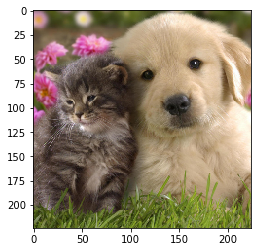

In [60]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [61]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [66]:
for i in range(10):
    print ' '.join(generate_caption(img,t=2.)[1:-1])

a brown cat and a cat bear and a table
a man standing in a table
a cat is is laying on a table
a bear is sitting on a bed
a cat that is a white bear and a dog
a boy is is in a table
a woman sitting in a small bear
a woman is sitting on a large table
a white living cat on a wall
a person is is is on a table


# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio (see what `preprocess` does to your image)

### excellent

a man is riding a surfboard
a man is is flying a wave
a man is riding a wave
a man is on a wave
a man is standing on a beach
two people riding a wave on the ocean
a man is standing on a snow
a man is is on a wave
a man is flying a wave on a wave
a man is riding a wave


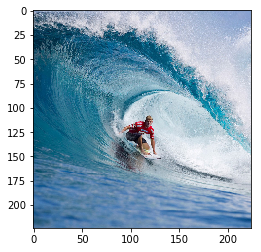

In [123]:
img = preprocess(plt.imread('data/img17.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=3.)[1:-1])

a man is standing on a beach
a man is flying a kite
a man is standing on a beach
a man is flying a kite
a man is flying a kite
a man is standing in the air
a man is flying a kite in the ocean
a man is flying a kite
a man is flying a kite on the ocean
a person flying a kite in the water


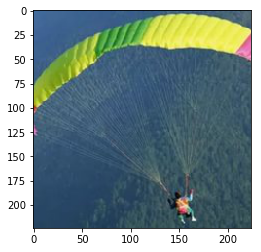

In [121]:
img = preprocess(plt.imread('data/img16.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=5.)[1:-1])

### nice

numerous park mouth inside up of people in the light
an skatepark cone with a fire racket and a train connected to notes
themed man sits against a snow next to a stone street
posing being playing produce and trees flag
street with a european sign that is bar
many people are at the brick street
a woman cooks holding the window watches a grazing on the road
side of people standing next to the
tennis
soldiers of luggage indoor picture of travel


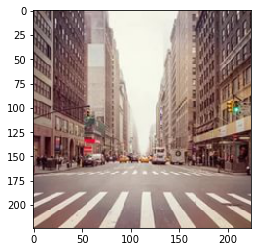

In [114]:
img = preprocess(plt.imread('data/img12.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

a white man is with a white black and white and white sink
there is a white white and white and white bathroom
a man is in a black bathroom
a person is in a black and white #UNK#
a white bathroom with a white toilet and a white toilet
a white bathroom with a white toilet
a woman is in a black bathroom
a man is is in a large white board
a man is sitting on a window
a man is standing on a wooden table


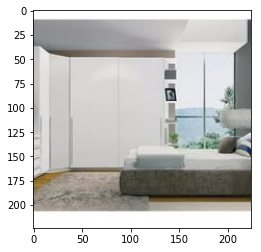

In [75]:
img = preprocess(plt.imread('data/img1.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=3.)[1:-1])

a man is riding a skateboard on the snow
a man is riding a skateboard on a snowy field
a man is riding a skateboard on a field
a man riding a skateboard in a skateboard
a man flying a skateboard at a skateboard
a man is riding a skateboard on a snow
a man riding a skateboard on the air
a man is riding a skateboard
a man riding a skateboard on a snow
a man is riding a skateboard on a park


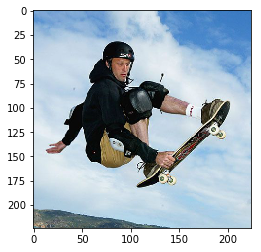

In [76]:
img = preprocess(plt.imread('data/img2.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=3.)[1:-1])

a man on a wave on a field
a man is on a field of a green field
a man is standing on a grass field
a man is standing on a fence
a man standing on a snowy field
a man walking on a field
a man is standing in a lush white field
a man is standing on the water
a dog is standing in the water
a man is standing in the grass


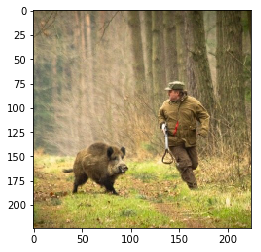

In [117]:
img = preprocess(plt.imread('data/img14.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=3.)[1:-1])

a woman is holding a small tie
a man in a dog in a table
a man is sitting on a bed
a woman is wearing a dog and a teddy bear
a man is looking down a couch
two woman sitting on a table
a man is in a bear with a umbrella
a woman is is standing in a table
two young teddy and girl are laying on a couch
a man is in a blue phone


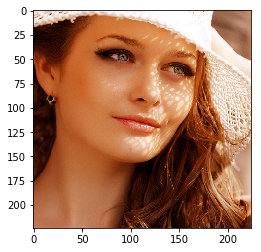

In [105]:
img = preprocess(plt.imread('data/img8.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=2.)[1:-1])

a woman holding a white table
a woman is holding a white bowl in a table
a person with a hot dog on a cell phone
a woman with a woman sitting on a table
a woman is sitting on a table with a laptop
white #UNK# is sitting on a table
girl is that is standing on a table
woman is sitting in a table with a table
a woman holding a cake with a teddy and white dog
a woman eating a cake with a cake


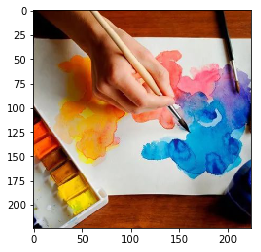

In [135]:
img = preprocess(plt.imread('data/img22.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=2.)[1:-1])

a man is standing on a beach
a man is riding a kite
a man holding a kite on a beach
a man is standing on a beach
a man is holding a kite on a beach
a man is holding a kite
a man is riding a skateboard on a beach
a man is standing on a beach
a man is standing on a skateboard
a man is standing on a beach


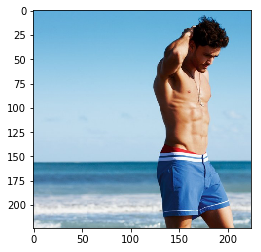

In [153]:
img = preprocess(plt.imread('data/img27.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=6.)[1:-1])

### bad

a man holding a cell phone on a skateboard
a man wearing a man holding a skateboard
a man holding a large white phone
a man is standing next to a laptop
a man is on a skateboard
a man in a man with a woman on a skateboard
a man wearing a man on a skateboard
a man is holding a cell phone
a man with a man on a skateboard
a man wearing a man on a skateboard


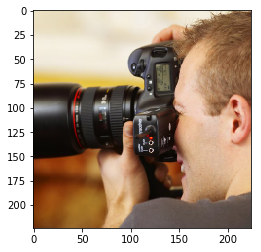

In [155]:
img = preprocess(plt.imread('data/img23.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=3.)[1:-1])

a man taking a blue board
a white man riding a skateboard
a man standing in the water
white airplane on a skateboard on the air
a person is holding a skateboard on the beach
a man rides a trick on a street
a man is on a green board
a woman on a wave on the ocean
a child is on his wave in the day
a very white board that is on the air


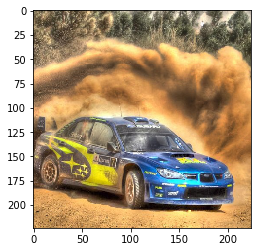

In [134]:
img = preprocess(plt.imread('data/img21.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=2.)[1:-1])

a group of people standing on a street
a man is riding a motorcycle on a street
a man is standing on a beach
a group of people are standing on a table
a man is riding a kite on a park
a man is riding a blue board on a road
a bunch of people standing on the side of a building
a man is standing on a sidewalk
a group of people are standing on a table
a man riding a kite on a park


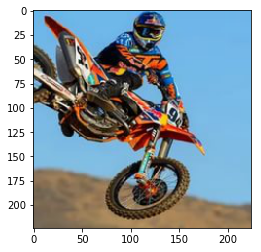

In [131]:
img = preprocess(plt.imread('data/img20.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=3.)[1:-1])

a man is sitting on a white desk
a woman is is on a chair
two people sitting on a water
a man is sitting on a table with a picture
a woman is on a car with a blue sky
a man is on a snowboard on a beach
a man is doing a wave
a person is sitting on a large bench
a man sitting on a bench on a beach
a man is looking on a skateboard


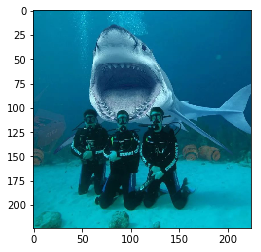

In [126]:
img = preprocess(plt.imread('data/img18.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=2.)[1:-1])

a man riding a skateboard on a street
a man riding a skateboard on a skateboard
a man in a red red board
a person riding a skateboard on a street
a man in a man on a skateboard
a man riding a snowboard on a skateboard
a man riding a skateboard on a street
a man in a man holding a skateboard
a man riding a skateboard in the air
a man riding a skateboard on a snowy slope


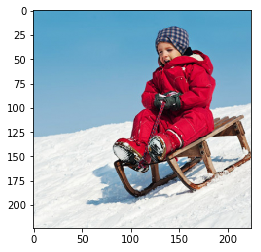

In [118]:
img = preprocess(plt.imread('data/img15.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=3.)[1:-1])

motor city birthday sized stopping lettering waiting inside
yellow parking slope is sitting on a wall
woman is a pink mug sitting on a motorcycle
a small man for white depicts a kite
rock adult of some and bananas leaning in a wall
silverware bears in a branch next to and flowers
young baby person in village side a river
everyone are holding base on the strawberries
vertically in green suit sitting against a giant tree
am group of sheep in not flight


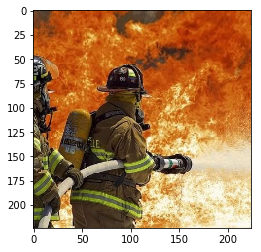

In [115]:
img = preprocess(plt.imread('data/img13.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

green bird is laying on a grass bench
a white bird is standing on a tree with a tree
a giraffe standing through a wooden tree
two bird standing on a field with a tree
brown bird standing on a tree with a tree
two white bird standing to a tree
two people standing on a field with a bird
white bird is in a small white field
black cat on a bird in a field
white bird standing in a field with a tree


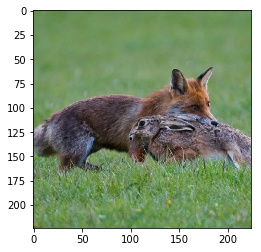

In [112]:
img = preprocess(plt.imread('data/img11.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=2.)[1:-1])

man lines of some catch here behind the beach
serve horses standing with fenced cool in the grass
end of high chipping grazing on drawers with they have other the home enclosure
blocking adult birds standing on a horse with white and opposite barn in a path
stone elephant are standing on a blue field
people polar bear next to each side
flat zebra is sheep and some birds in the water
well couple of people are eat in the water walk
smiling giraffe under a large texas body is them
two lone yellow brunette herding green animals running down in the lush green water


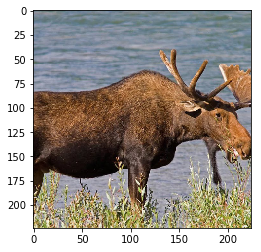

In [110]:
img = preprocess(plt.imread('data/img10.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

a group of people riding a street
a man parked down a street with a building
a man is riding a skateboard on a road
a man riding a motorcycle on a street
a woman is riding a skateboard on a field
red man and a motorcycle on a kite
a man is standing in a street
a man that is standing on a street
a man on a skateboard in a road
a man riding a skateboard in a street


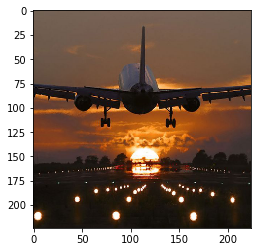

In [106]:
img = preprocess(plt.imread('data/img9.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=2.)[1:-1])

hand are eating a terrier and woman
a man in a pair of a pastry
one woman posing to a remote reading a pink shoulders
children is has kids with a soccer
leash uses a small picture of a bathroom
a young boy is talking in up idly
black man on a watched of a baseball bench
a group that are flown eating a older umbrella left
glasses paved umbrella and a brown and man holding a pair of him
baby small boy wearing green nice guy out to ready to it


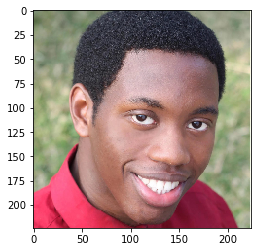

In [89]:
img = preprocess(plt.imread('data/img7.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

a man wearing a suit is sitting on a bench
a man is sitting on a bench
a man standing in a bench
a woman standing on a bench
a man is standing on a bench
a woman holding a shirt holding a frisbee
a man is standing on a bench
a man holding a umbrella in a hand
a man wearing a tie and a umbrella
a man holding a tie in a blue


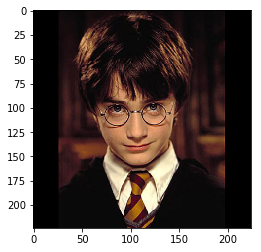

In [87]:
img = preprocess(plt.imread('data/img6.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=3.)[1:-1])

boarding a group of getting getting play soccer
skateboarder playing shirts and pants leaning the #UNK#
a animal holding a womans surfboard
shows girl with a white stuffed cake
a man flying a tennis racket
woman is returning a racket
gray very grooming plaid standing that is wearing each ball
country close up of food watching one umpire
a woman wearing an meadow with kites tables
older man on a mitt holding fruit and books


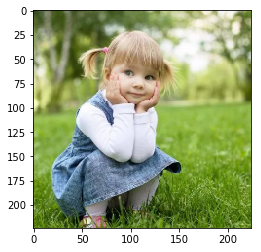

In [86]:
img = preprocess(plt.imread('data/img5.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

clothes high carrying a body of yellow cupboard
a giraffe riding on #UNK# two skis in a field
#UNK# some picnic are as lots of a horse
multi line eating ride flying in the water
view of a family of pitcher mouths one in his abandoned wind
a man looking on a surf field
a young group of young dog is art surfboards in the hill
two long couple of large animal putting animals
jeans and playing frisbee in a field
people graze in a outdoor ball


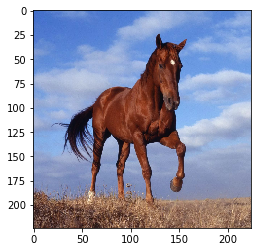

In [82]:
img = preprocess(plt.imread('data/img3.jpeg'))
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

# grading

* base 5 if it compiles and trains without exploding
* +1 for finding representative set of reference examples
* +2 for providing 10+ examples where network provides reasonable captions (at least sometimes :) )
  * you may want to predict with sample=False and deterministic=True for consistent results
  * kudos for submitting network params that reproduce it
* +2 for providing 10+ examples where network fails IF you also got previous 10 examples right


* bonus points for experiments with architecture and initialization (see above)
* bonus points for trying out other pre-trained nets for captioning
* a whole lot of bonus points if you also train via metric learning
 * image -> vec
 * caption -> vec (encoder, not decoder)
 * loss = correct captions must be closer, wrong ones must be farther
 * prediction = choose caption that is closest to image
* a freaking whole lot of points if you also obtain statistically signifficant results the other way round
 * take caption, get closest image